In [1]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import cv2

## Load Pandas Dataframe

In [324]:
albums_df = pd.read_pickle("./albums_df_s3.pkl")

In [325]:
v1 = albums_df.has_face 

In [326]:
v2 = albums_df.hog_descriptor

In [327]:
v3 = albums_df.hsv_hist

In [352]:
feature =[]

for index,_ in v2.items():
    c = np.append( v1[index],v2[index])
    feature.append(np.append(c,v3[index]))


albums_df['X'] = feature

In [1]:
from sklearn.model_selection import train_test_split

y = np.array(albums_df['album_popularity'])
y

X = albums_df.X 

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.3, 
    shuffle=True,
    random_state=42,
    stratify=y
)

NameError: name 'np' is not defined

In [354]:
def transform(X):
    return np.array([x for x in X],  dtype="object")

X_train = transform(X_train)
X_test = transform(X_test)

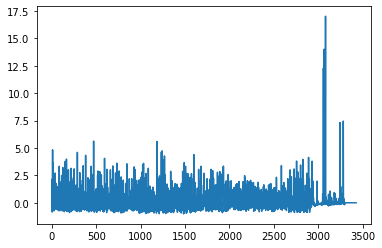

In [363]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler

X_train_prepared = StandardScaler().fit_transform(X_train)
X_test_prepared = StandardScaler().fit_transform(X_test)

#Normalize The feature vectors...
scaler = MinMaxScaler(feature_range=(0, 1))
#X_train_prepared = scaler.fit_transform(X_train_prepared)
#X_test_prepared = scaler.fit_transform(X_test_prepared)


plt.plot(X_train_prepared[4])

In [124]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from skimage.color import rgb2gray
import skimage

class RGB2GrayTransformer(BaseEstimator, TransformerMixin):
    """
    Convert an array of RGB images to grayscale
    """
 
    def __init__(self):
        pass
 
    def fit(self, X, y=None):
        """returns itself"""
        return self
 
    def transform(self, X, y=None):
        """perform the transformation and return an array"""
        return np.array([ rgb2gray(img).flatten() for img in X],  dtype="object")

class HogTransformer(BaseEstimator, TransformerMixin):
    """
    Expects an array of 2d arrays (1 channel images)
    Calculates hog features for each img
    """
 
    def __init__(self, y=None, orientations=9,
                 pixels_per_cell=(8, 8),
                 cells_per_block=(3, 3), block_norm='L2-Hys'):
        self.y = y
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.block_norm = block_norm
 
    def fit(self, X, y=None):
        return self
 
    def transform(self, X, y=None):
 
        def local_hog(X):
            return hog(X,
                       orientations=self.orientations,
                       pixels_per_cell=self.pixels_per_cell,
                       cells_per_block=self.cells_per_block,
                       block_norm=self.block_norm)
 
        try: # parallel
            return np.array([local_hog(img) for img in X],  dtype="object")
        except:
            return np.array([local_hog(img) for img in X],  dtype="object")

hogify = HogTransformer(
    pixels_per_cell=(14, 14), 
    cells_per_block=(2,2), 
    orientations=9, 
    block_norm='L2-Hys'
)


X_train_gray = RGB2GrayTransformer().fit_transform(X_train)
type(X_train_gray)
#X_train_hog = hogify.fit_transform(X_train_gray)
X_train_prepared = StandardScaler().fit_transform(X_train_gray)


<ipython-input-124-047b5f959be9>:20: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  return np.array([ rgb2gray(img).flatten() for img in X],  dtype="object")


In [334]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier, LinearRegression

In [364]:
sgd_clf = SGDClassifier(random_state=42, max_iter=1000, tol=1e-3)
sgd_clf.fit(X_train_prepared, y_train)

SGDClassifier(random_state=42)

In [336]:
X_train_prepared[0].shape
# y_train.shape
reg = LinearRegression(normalize=False).fit(X_train_prepared, y_train)
reg.score(X_train_prepared, y_train)

y_pred = reg.predict(X_train_prepared)
#y_pred = reg.predict(X_test_prepared)
 

y_pred

array([69.59904204, 68.23974311, 63.73853679, ..., 71.90018462,
       76.70001132, 69.7189127 ])

In [374]:
y_pred = sgd_clf.predict(X_train_prepared)

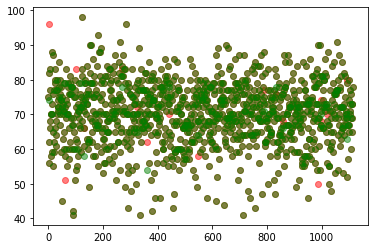

In [366]:
plt.plot(y_pred ,'ro', alpha = 0.5)
plt.plot(y_train ,'go', alpha = 0.5)

In [375]:
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, roc_auc_score

rms = mean_squared_error(y_train, y_pred, squared=False)

rms

r2_score(y_train, y_pred), rms

(0.9661945037671679, 1.6508525625033503)

In [368]:
y_pred = sgd_clf.predict(X_test_prepared)

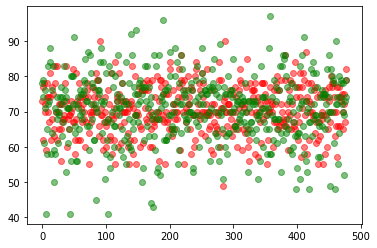

In [369]:
plt.plot(y_pred ,'ro', alpha = 0.5)
plt.plot(y_test ,'go', alpha = 0.5)

In [372]:
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, roc_auc_score

rms = mean_squared_error(y_test, y_pred, squared=False)

r2_score(y_test, y_pred) , rms

(-0.40410119887724405, 11.011310275116918)